# Install dependencies

In [29]:
# # before running this, make sure to "FACTORY" reset the runtime to clear memory.
# import ipdb # helpful for debugging, lets you add breakpoints... or at least, is on the right path toward that functionality. If running this in a Colab environment, it won't work, hence why it's commented out.

In [30]:
import torch
import random

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm, trange

In [31]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [32]:
# # magic command enables breakpoints with "on". Better to comment it out when in a Colab environment
# %pdb off

# Set device

In [33]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

DEVICE = set_device()

GPU is enabled in this notebook.


# Deal with the MNIST dataset

In [34]:
# # before running this, make sure to "FACTORY" reset the runtime to clear memory.
mnist_train = datasets.MNIST(root='./MNIST/train', train=True, download=True, transform=transforms.ToTensor())
mnist_test  = datasets.MNIST(root='./MNIST/test', train=False, download=True, transform=transforms.ToTensor())

In [35]:
# # or, use EMNIST to include letters in the mix
# # except wait... are some of these rotated & otherwise transformed?
# # if so, that explains why the VAE is struggling so hard
# # hmmm no I think the data in this dataset are just transposed
# targettransform = transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Lambda(lambda x: torch.transpose(x,1,2))
# ])

# # let's not merge & balance classes. let's keep ALL of them: 26 lowercase, 26 uppercase, 10 numerals
# # otherwise it's unintuitive why we only consider a few of the lowercase letters (with some of the default merged lowercase letters, such as i, totally being discriminable anyway!)
# mnist_train = datasets.EMNIST(root='./EMNIST',split='byclass',train=True,download=True,transform=targettransform)
# mnist_test  = datasets.EMNIST(root='./EMNIST',split='byclass',train=False,download=True,transform=targettransform)
# # emnist just dumps everything in the target directory
# # hmmm okay just use mnist regular style. The EMNIST dataset, at least pulled in this manner, is simply too big and I have yet to do the requisite memory management to squeeze it onto my GPU...

# Train & Validation splitting

In [36]:
def MakeDataDict(trainset: Dataset, testset: Dataset) -> dict:
  # split training set into training & validation sets
  nsamples = len(trainset)

  trainsz = int(0.8*nsamples)
  validsz = int( nsamples - trainsz )

  outdict = dict()
  outdict['train'], outdict['valid'] = \
  torch.utils.data.random_split(trainset,[trainsz,validsz])

  outdict['test'] = testset

  return outdict

mnist_datadict = MakeDataDict(mnist_train,mnist_test)

# VAE definition

# Re-implement in a way that actually makes sense to you

In [37]:
k = 2 # number of features (don't crank the D up too high, otherwise your generation function just spits out the global average luminance pattern) (not sure if that's a function of over-weighting the latent KLD or a function of how impractical it is to randomly sample a, say, 100-dimensional space and cover the full repertoire represented therein)
im = mnist_datadict['train'][0][0] 
imshape = im.shape # two lines to get the shape of the input

In [38]:
# Helper net: this allows us to have pixel-by-pixel bias terms
class BiasLayer(nn.Module):
  def __init__(self, shape):
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    return x + self.bias

# loss definitions
def NLLloss(y: torch.Tensor,yhat: torch.Tensor,logvar: torch.Tensor) -> torch.Tensor:
  # todo: add support for when we sample multiple points about each image's projection in latent space
  y_ = y.flatten()
  yhat_ = yhat.flatten()

  sqresids   = (y_ - yhat_)**2
  sigma2     = torch.exp(logvar.flatten())
  logfactors = logvar.flatten() + 0.5*torch.log(2*torch.tensor(np.pi))

  # f(x) = 1/(sigma*sqrt(2*pi)) * exp(-0.5*(x-mu)**2 / sigma2)
  # logf = -log(sigma2) - 0.5*log(2*pi) - 0.5*(x-mu)**2/sigma2
  #        | -logfactors               | -sqresids/(sigma2)
  # nll  = -logf = logfactors + sqresids/(sigma2)
  # classically, we would just ignore the logfactors, but since we need to weight this against our prior, we account for it
  # although I can't shake the feeling that this summation doesn't quite work because the latent space is conditioned differently than pixel-space...
  nll = logfactors + sqresids/(2*sigma2)

  sumnll = nll.sum()

  return sumnll

def KLDloss(mu: torch.Tensor,loglatentvar: torch.Tensor) -> torch.Tensor:
  # KLD of inferences w.r.t. N(0,1)
  sigma2 = torch.exp(loglatentvar)
  # ipdb.set_trace() # debugging array sizes and incorrect broadcasting in following line
  kld = 0.5*( sigma2 + (mu**2).T - 1 - loglatentvar ) # from wikipedia: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions
  kld = kld.T # transpose in previous line, detranspose in this line, to get python to broadcast things correctly
  sumkld = kld.sum()
  return sumkld

def VAEloss(y: torch.Tensor,yhat: torch.Tensor,mu: torch.Tensor,logvar: torch.Tensor,loglatentvar: torch.Tensor) -> torch.Tensor:
  # here we calculate ELBO
  # KLD can be thought of as the expected LL of a sample given a proposed distribution
  # in other words, the expected LL of our model per se, since we take the N(0,1) from which our latent embeddings are drawn as truth per se
  # let's get bayesian:
  # p(theta|x) = p(x|theta) * p(theta) / p(x)
  # logp(theta|x) = logp(x|theta) + logp(theta) - logp(x)
  # logp(theta|x) is our target: how likely is our model given the data?
  # logp(x|theta) is the likelihood of our data given the model - i.e., the NLL
  # logp(theta) is the likelihood of our model per se - i.e., the KLD of the embeddings of all our samples given our absolute truth of N(0,1) generating our latent samples
  # logp(x) is the likelihood of our data per se. Model parameters do not affect this at all, so we just ignore it
  nlll = NLLloss(y,yhat,logvar)
  kldl = KLDloss(mu,loglatentvar)
  vael = nlll + kldl
  return vael

# define net
class ConvVAE(nn.Module):
  def __init__(self, K, data_shape, num_filters=32, filter_size=(5,5), pool_size=(2,2), filter_stride_size=(1,1), pool_stride_size=(1,1)):
    super(ConvVAE, self).__init__()

    # forget about batch normalization, dropout, etc. for now. you're already regularizing with the variational principle, anyway

    # encoder net layers
    # note: do NOT add max pooling. the inverse operation is very janky and requires you to cleverly embed argmax indices somehow, which is just too complicated for this simple little demo
    # those indices CAN be obtained via return_indices when using MaxPool2d, which gives a tuple of tensors, first being values, second being argmax indices
    # BUT here's the rub: when you then want to simply GENERATE numerals from random noise, you're gonna need an embedding of those indices in the latent space to then pull out those indices and plug them into the janky inverse maxpool layers
    # and I don't feel like figuring out that embedding at this juncture
    # I mean, what does this look like? a visual transformer?
    self.bias0 = BiasLayer(data_shape)
    self.conv0 = nn.Conv2d(in_channels=data_shape[0],out_channels=num_filters,kernel_size=filter_size,stride=filter_stride_size)
    self.conv1 = nn.Conv2d(in_channels=num_filters,out_channels=num_filters,kernel_size=filter_size,stride=filter_stride_size)
    self.flatten0 = nn.Flatten() # x.view(x.size()[0], -1), the less elegant way

    # find the size of the output after all the conv layers I defined above
    shrunksize = [data_shape[ii+1]-2*(filter_size[ii]-1) for ii in range(len(filter_size))]

    self.shape_after_conv = [num_filters] + shrunksize

    flatsize         = np.prod(self.shape_after_conv)

    self.mlp0        = nn.Linear(in_features=flatsize,out_features=K+1) # add 1 to account for the variance estimate of each exemplar


    # decoder net layers
    self.demlp0      = nn.Linear(in_features=K,out_features=flatsize)
    self.unflatten0  = nn.Unflatten(-1,self.shape_after_conv) # -1 means the final dimension is unflattened. Similar to array indexing in general. This behavior is VERY poorly documented, though.
    self.deconv1     = nn.ConvTranspose2d(in_channels=num_filters,out_channels=num_filters,kernel_size=filter_size,stride=filter_stride_size)
    self.deconv0     = nn.ConvTranspose2d(in_channels=num_filters,out_channels=data_shape[0],kernel_size=filter_size,stride=filter_stride_size)
    self.debias0     = BiasLayer(data_shape)

    # Define a special extra parameter to learn scalar sig_x for all pixels
    # it'll define its own size later
    self.logvar      = nn.Parameter(torch.zeros(()))

  # VAE version of "encode"
  def infer(self, x):
    # ipdb.set_trace() # at one point I forgot how I was doing max pooling and put this here to solve the mystery. I then decided that max pooling (and the inverse thereof) was simply too complicated to add to this cute little demo.
    phi = self.bias0(x)
    phi = F.relu(self.conv0(phi))
    phi = F.relu(self.conv1(phi))
    # ipdb.set_trace() # used this one to debug an off-by-one error in my shape_after_conv calculation
    phi = self.flatten0(phi)
    phi = self.mlp0(phi) # not actually an MLP since there's no ReLU after
    return phi

  def sample(self, phi): # strictly speaking this could just be a static method
    b,kplus1 = phi.size() # (b)atch X (k)features
    k        = kplus1 - 1
    mu, sig  = phi[:,:-1], phi[:,-1].exp()
    eps      = torch.randn(b,k,device=phi.device)
    z        = eps*sig.view(b,1) + mu.view(b,k) # vectorize pixel residual sigma and trust pytorch to broadcast properly
    return z

  # VAE version of "decode"
  def generate(self, z):
    z_ = self.demlp0(z)
    z_ = self.unflatten0(z_)
    z_ = self.deconv1( F.relu(z_) )
    z_ = self.deconv0( F.relu(z_) )
    mu = self.debias0(z_)
    return mu

  def forward(self, x):
    phi = self.infer(x)
    z   = self.sample(phi)
    mu  = self.generate(z)
    return mu

  def elbo(self, x):
    # VAEloss(y: torch.Tensor,yhat: torch.Tensor,mu: torch.Tensor,logvar: torch.Tensor,loglatentvar: torch.Tensor) -> torch.Tensor:
    phi  = self.infer(x)
    mu, logsig  = phi[:,:-1], phi[:,-1]
    z    = self.sample(phi)
    mu_x = self.generate(z)

    ELBO = VAEloss(x,mu_x,mu,self.logvar,logsig*2) #logsig is log sigma (makes it easier for the generate function), we want log sigma**2 for this calc tho

    return ELBO # actually negative ELBO oh well

In [39]:
def train_vae(vae, trainset, validset, epochs=20):
  opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=0)
  train_elbo_vals = []
  valid_elbo_vals = []
  vae.to(DEVICE)
  vae.train() # switch to "train" mode. It doesn't do anything here, but it's good practice for when you add dropout / batchnorm / various other things that DO change between train & eval modes
  loader  = DataLoader(trainset, batch_size=250, shuffle=True, pin_memory=True) # ain't it weird that pytorch abstracts all this away? just me? okay.
  vloader = DataLoader(validset,batch_size=250,shuffle=True,pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    vae.train()
    iter_count=0
    for im, _ in tqdm(loader, total=len(trainset) // 250, desc='Batches', leave=False):
      im = im.to(DEVICE)
      opt.zero_grad()
      loss = vae.elbo(im)
      loss.backward()
      opt.step()

      # second output of DATA LOADER which is called by tqdm is the class labels of the minibatch
      train_elbo_vals.append(loss.item())
      iter_count+=1

    vae.eval()
    vloss = 0
    for im,_ in tqdm(vloader, total=len(validset)//250, desc='ValidBatches', leave=False):
      im = im.to(DEVICE)
      vloss = vloss + vae.elbo(im)
    
    vloss = vloss / iter_count
    for ii in range(iter_count):
      valid_elbo_vals.append(vloss.item())

  vae.to('cpu')
  vae.eval() # switch back to "evaluate" mode
  return train_elbo_vals, valid_elbo_vals

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

ValidBatches:   0%|          | 0/48 [00:00<?, ?it/s]

Learned pixel variance is 0.02002827078104019


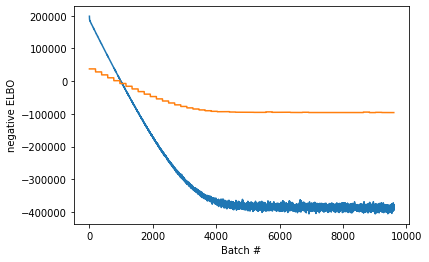

In [40]:
trained_conv_VarAE = ConvVAE(K=k,data_shape=imshape)
elbo_vals, valid_elbo_vals = train_vae(trained_conv_VarAE, mnist_datadict['train'], mnist_datadict['valid'], epochs=50)

print(f'Learned pixel variance is {torch.exp(trained_conv_VarAE.logvar)}')

# Uncomment below if you'd like to see the the training
# curve of the evaluated ELBO loss function
# ELBO is the loss function used to train VAEs
plt.figure()
plt.plot(elbo_vals)
plt.plot(valid_elbo_vals)
plt.xlabel('Batch #')
plt.ylabel('negative ELBO')
plt.show()

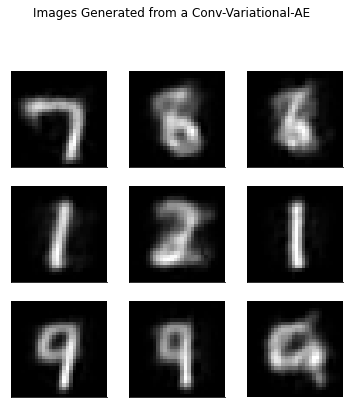

In [41]:
# generate images from noise (how character-like do they look? is this a good generative model?)
def generate_images(autoencoder, K, data_shape, n_images=1):
  """Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  returns (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + data_shape # funny concat syntax but ok, guess that's how python handles it
  with torch.no_grad():
    # sample z from a unit gaussian, pass through autoencoder.decode()
    z = torch.randn(n_images, K)
    x = autoencoder.generate(z)

    return x.reshape(output_shape)

# helper functions
def plot_torch_image(image, ax=None):
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # Torch images have shape (channels, height, width) but matplotlib expects
  # (height, width, channels) or just (height,width) when grayscale
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

def plot_images(images, h=3, w=3, plt_title=''):
  plt.figure(figsize=(h*2, w*2))
  plt.suptitle(plt_title, y=1.03)
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])
  plt.axis('off')
  plt.show()

images = generate_images(trained_conv_VarAE, k, imshape, n_images=9)
plot_images(images, plt_title='Images Generated from a Conv-Variational-AE')

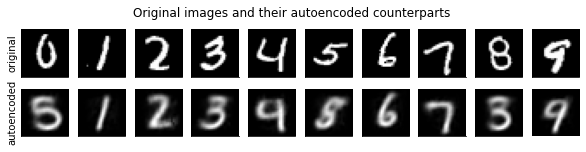

In [42]:
# look at 9 before-and-after examples in the test set (how well does it match? is it a good autoencoder?) (depends on previous cell)
def matching_images(autoencoder, test_dataset, n_images=1):
  labels = [test_dataset[ii][1] for ii in range(len(test_dataset))]
  ulabs  = set(labels)

  sampled_inds = []
  for ii in range(len(ulabs)):
    these_indices = [jj for jj in range(len(labels)) if labels[jj]==ii]
    ninds         = len(these_indices)
    ind2pick      = random.randrange(0,ninds) # randint is *inclusive*. because of COURSE there has to be weird shit...
    realind2pick  = these_indices[ind2pick]
    sampled_inds.append(realind2pick)

  sourcetensors = [test_dataset[jj][0] for jj in sampled_inds]
  gentensors    = [torch.squeeze(autoencoder.forward(torch.unsqueeze(im,0)),dim=0) for im in sourcetensors]

  return sourcetensors, gentensors # a list of tensors instead of a single concatenated tensor. I know, I'm a bad, bad man, but y'know what? I don't feel like unsqueezing today.

def plot_match_images(sourcetensors,gentensors,plt_title=''):
  nimgs = len(sourcetensors)
  plt.figure(figsize=(nimgs,2))
  plt.suptitle(plt_title,y=1.03)
  for ii in range(nimgs):
    plt.subplot(2,nimgs,ii+1)
    plot_torch_image(sourcetensors[ii]) # use the same helper method to convert from pytorch tensors to nice images. this means you gotta run the cell above for this one to work!!!
    if ii == 0:
      plt.ylabel('original')
    plt.subplot(2,nimgs,nimgs+ii+1)
    plot_torch_image(gentensors[ii])
    if ii == 0:
      plt.ylabel('autoencoded')
  plt.axis('off')
  plt.show()

st,gt = matching_images(trained_conv_VarAE, mnist_test)
plot_match_images(st,gt,plt_title='Original images and their autoencoded counterparts')

# trade-off
more dimensions = better reconstruction

BUT

more dimensions = less feasible random sampling of latent space, ergo, worse generated exemplars

ergo, we have a trade-off to characterize